In [142]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preproc
import py_pcha
from sklearn.neighbors import KNeighborsClassifier
import random
import copy
import random
from datetime import datetime


import seaborn as sns

In [2]:
# Globals
_SEED = 0

In [3]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [4]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [5]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [6]:
# # filter labels
# def filter_by_age(df, fromAge, toAge):
#     return df[(df.age >= fromAge) & (df.age <=toAge)]

In [7]:
# filtered_labels = filter_by_age(labels, 10, 30 )
# filtered_labels

In [8]:
# #Select images from dataset using filtered_labels
# X = np.empty((len(filtered_labels), h*w))

# for i, index in enumerate(filtered_labels.index):
#     #print(i,index)
#     a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
#     a = img_as_ubyte(a)
#     X[i, :] = a.reshape(1, -1)
    
# del a
# print('Done loading images')

In [9]:
#Generate random indexes for sampling
total_n_faces = 23704
subset_length = 5000
random_indexes = []
for i in range(0, subset_length):
    n = random.randint(0,total_n_faces)
    random_indexes.append(n)


In [10]:
#Select images from dataset using random indexes
X = np.empty(shape = (subset_length, h*w))

for i, index in enumerate(random_indexes):
    #print(i,index)
    a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
    
del a
print('Done loading images')

Done loading images


In [11]:
filtered_labels = labels.iloc[random_indexes]

In [136]:
method = 'AA'

#Archetypal analysis (KNN commented out)
if method == 'AA':
    #Reference to book notation
    '''
    B = C.T
    W = S.T
    H = XC.T
    SSE = Sum of Squared Errors
    '''
    
    for n_comp in [10, 15, 20, 50]:
        # Does not require that you center data
        XC, S, C, SSE, varexpl = py_pcha.PCHA(X.T, noc=n_comp, delta=0.1)
        X_hat = X.T @ C @ S
        L = 0.5*np.linalg.norm(X.T-X_hat)**2
        components = XC.T
        SST = np.sum(np.sum(X**2))
        
        outfile = str(n_comp) + "_comp_XC"
        np.save("Matrices\\" + outfile, XC)
        outfile = str(n_comp) + "_comp_S"
        np.save("Matrices\\" + outfile, S)
        outfile = str(n_comp) + "_comp_C"
        np.save("Matrices\\" + outfile, C)
        outfile = str(n_comp) + "_comp_SSE"
        np.save("Matrices\\" + outfile, SSE)
        outfile = str(n_comp) + "_comp_varexpl"
        np.save("Matrices\\" + outfile, varexpl)
        outfile = str(n_comp) + "_comp_X_hat"
        np.save("Matrices\\" + outfile, X_hat)
        outfile = str(n_comp) + "_comp_L"
        np.save("Matrices\\" + outfile, L)
        outfile = str(n_comp) + "_comp_SST"
        np.save("Matrices\\" + outfile, SST)
        
        del outfile


    #knn.fit(S.T,ytrain)
    # Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
    #acc = knn.score(Xtest_transform.T,ytest)
    # X_test_hat = (XC @ Xtest_transform).T



#NMF
elif method == 'NMF':
    # Create model init method is set to random
    model = decomposition.NMF(n_components=n_components, init='random', random_state=0)
    X_transformed = model.fit_transform(X)
    L = 0.5*model.reconstruction_err_**2
    components = model.components_ # H
    
    # knn.fit(X_train_transformed,ytrain)
    # acc = knn.score(model.transform(Xtest),ytest)
    # X_test_hat = model.transform(Xtest).dot(model.components_)

KeyboardInterrupt: 

In [139]:
#Reload variables
n_components = 7
matrices_path = "Matrices\\"
C = np.load(matrices_path + str(n_components) + "_comp_C.npy")
L = np.load(matrices_path + str(n_components) + "_comp_L.npy")
S = np.load(matrices_path + str(n_components) + "_comp_S.npy")
SSe = np.load(matrices_path + str(n_components) + "_comp_SSE.npy")
SST = np.load(matrices_path + str(n_components) + "_comp_SST.npy")
varexpl = np.load(matrices_path + str(n_components) + "_comp_varexpl.npy")
X_hat = np.load(matrices_path + str(n_components) + "_comp_X_hat.npy")
XC = np.load(matrices_path + str(n_components) + "_comp_XC.npy")

In [57]:
np.sort(C.T[0])

array([0.        , 0.        , 0.        , ..., 0.09247897, 0.10783635,
       0.14171648])

In [64]:
#Get indexes of the samples more significant for the archetypes
Xmain = np.zeros((n_components,3))
for i in range(len(C.T)):
    Xmain[i,:] = np.flip(np.argsort(C.T[i]))[:3]
Xmain = Xmain.astype(int) #Main samples indexes for each component
    
arch_len = np.array(range(len(Xmain))).reshape(-1,1)
arch_main = np.append(arch_len, Xmain, axis = 1) #Archetype indexes and main samples indexes

In [154]:
#Plotting functions
n_rows = 7 #for plotting
n_cols = 7 #for plotting

left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (h, w)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    #start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())
        
    #Runtime to save different files
    now = datetime.now()
    current_time = now.strftime("%H%M%S")    
    
    plt.savefig(f'Archetypes\Arch_{current_time}_{n_comp}comp.png')
    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 210)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())
    
    #Runtime to save different files
    now = datetime.now()
    current_time = now.strftime("%H%M%S")    
    
    plt.savefig(f'Reconstructions\Recons_{current_time}_{n_comp}comp.png')
    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_arch_contributors(title, arch_main):
    '''
    Plot each archetype (first column) and the three most contributive samples that 
    define them
    '''
    #plt.figure(figsize=(image_shape[0]/100 * n_components, image_shape[1]/100 * np.shape(arch_main)[1]))
    plt.figure(figsize= (image_shape[1]/90 * np.shape(arch_main)[0], image_shape[0]/40 * n_components))
    plt.suptitle(title, size=24)
    pos = 0
    j = 0
    while j < len(arch_main):  
        for i, sample in enumerate(arch_main[j]):
            pos += 1
            if i == 0:
                comp = XC.T[sample,:]
            else:
                comp = X[sample,:]
            plt.subplot(n_components, np.shape(arch_main)[1], pos)
            # normalize colormap
            vmax = max(comp.max(), -comp.min())
            plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                       interpolation='nearest',
                       vmin=-vmax, vmax=vmax)
            # Remove ticks from plot
            plt.xticks(())
            plt.yticks(())
        j += 1
        
    #Runtime to save different files
    now = datetime.now()
    current_time = now.strftime("%H%M%S")    
    
    plt.savefig(f'Archetypes_Contributors\ArchContr_{current_time}_{n_comp}comp.png')
    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

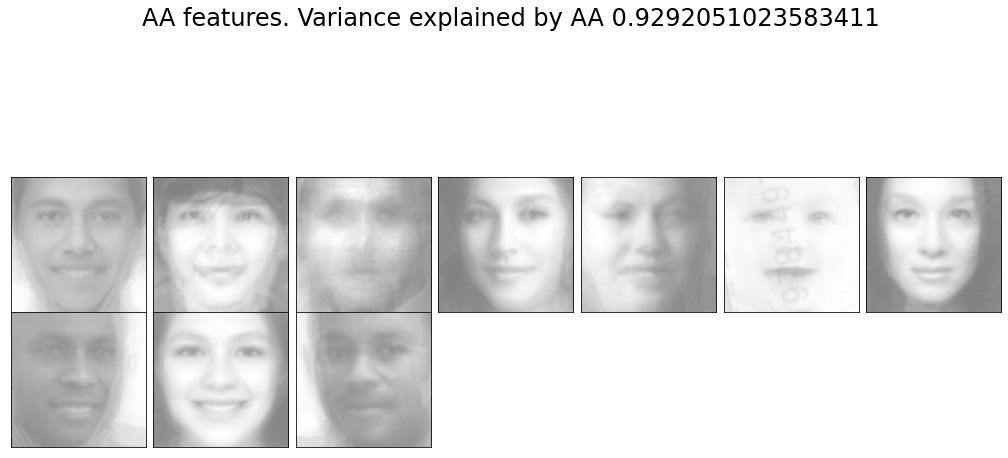

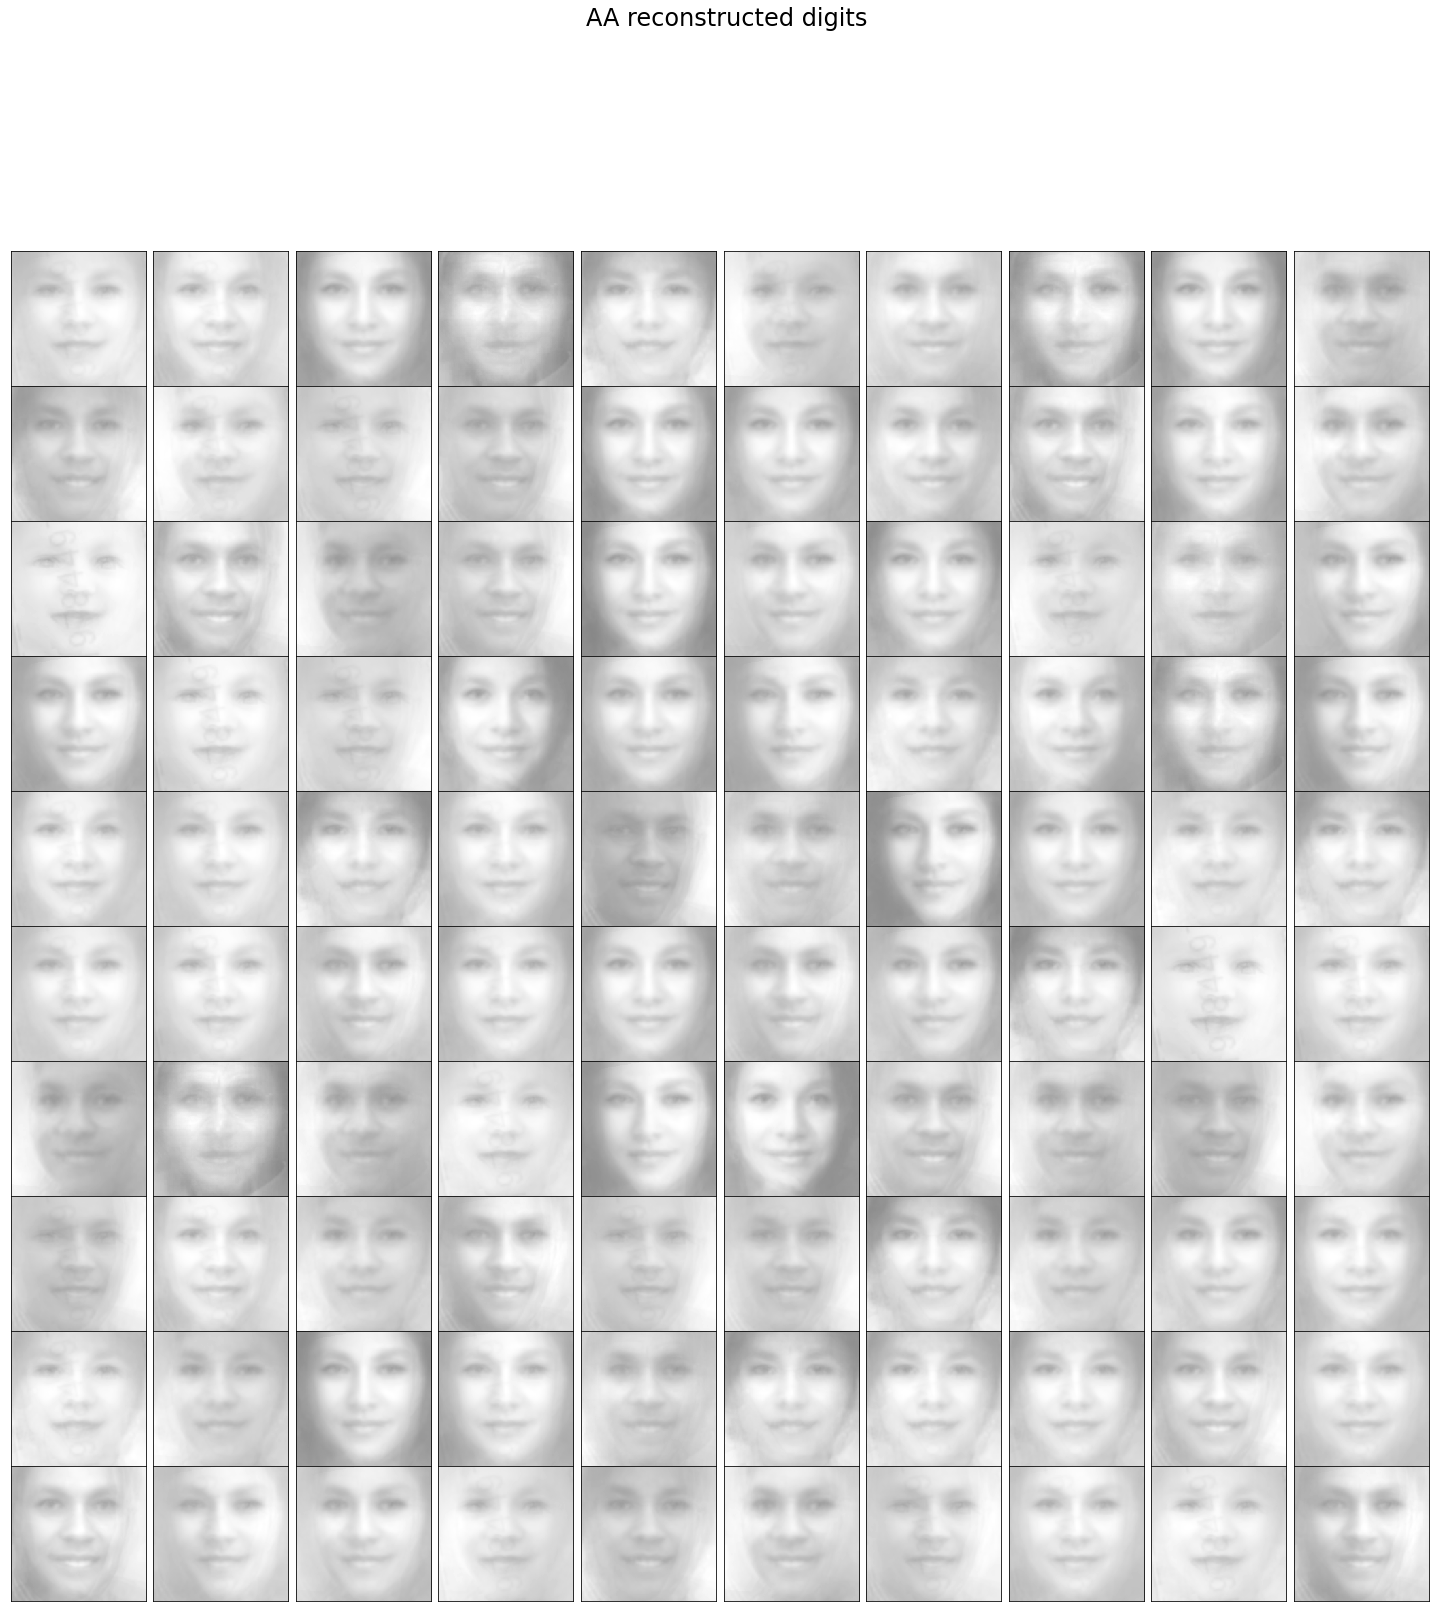

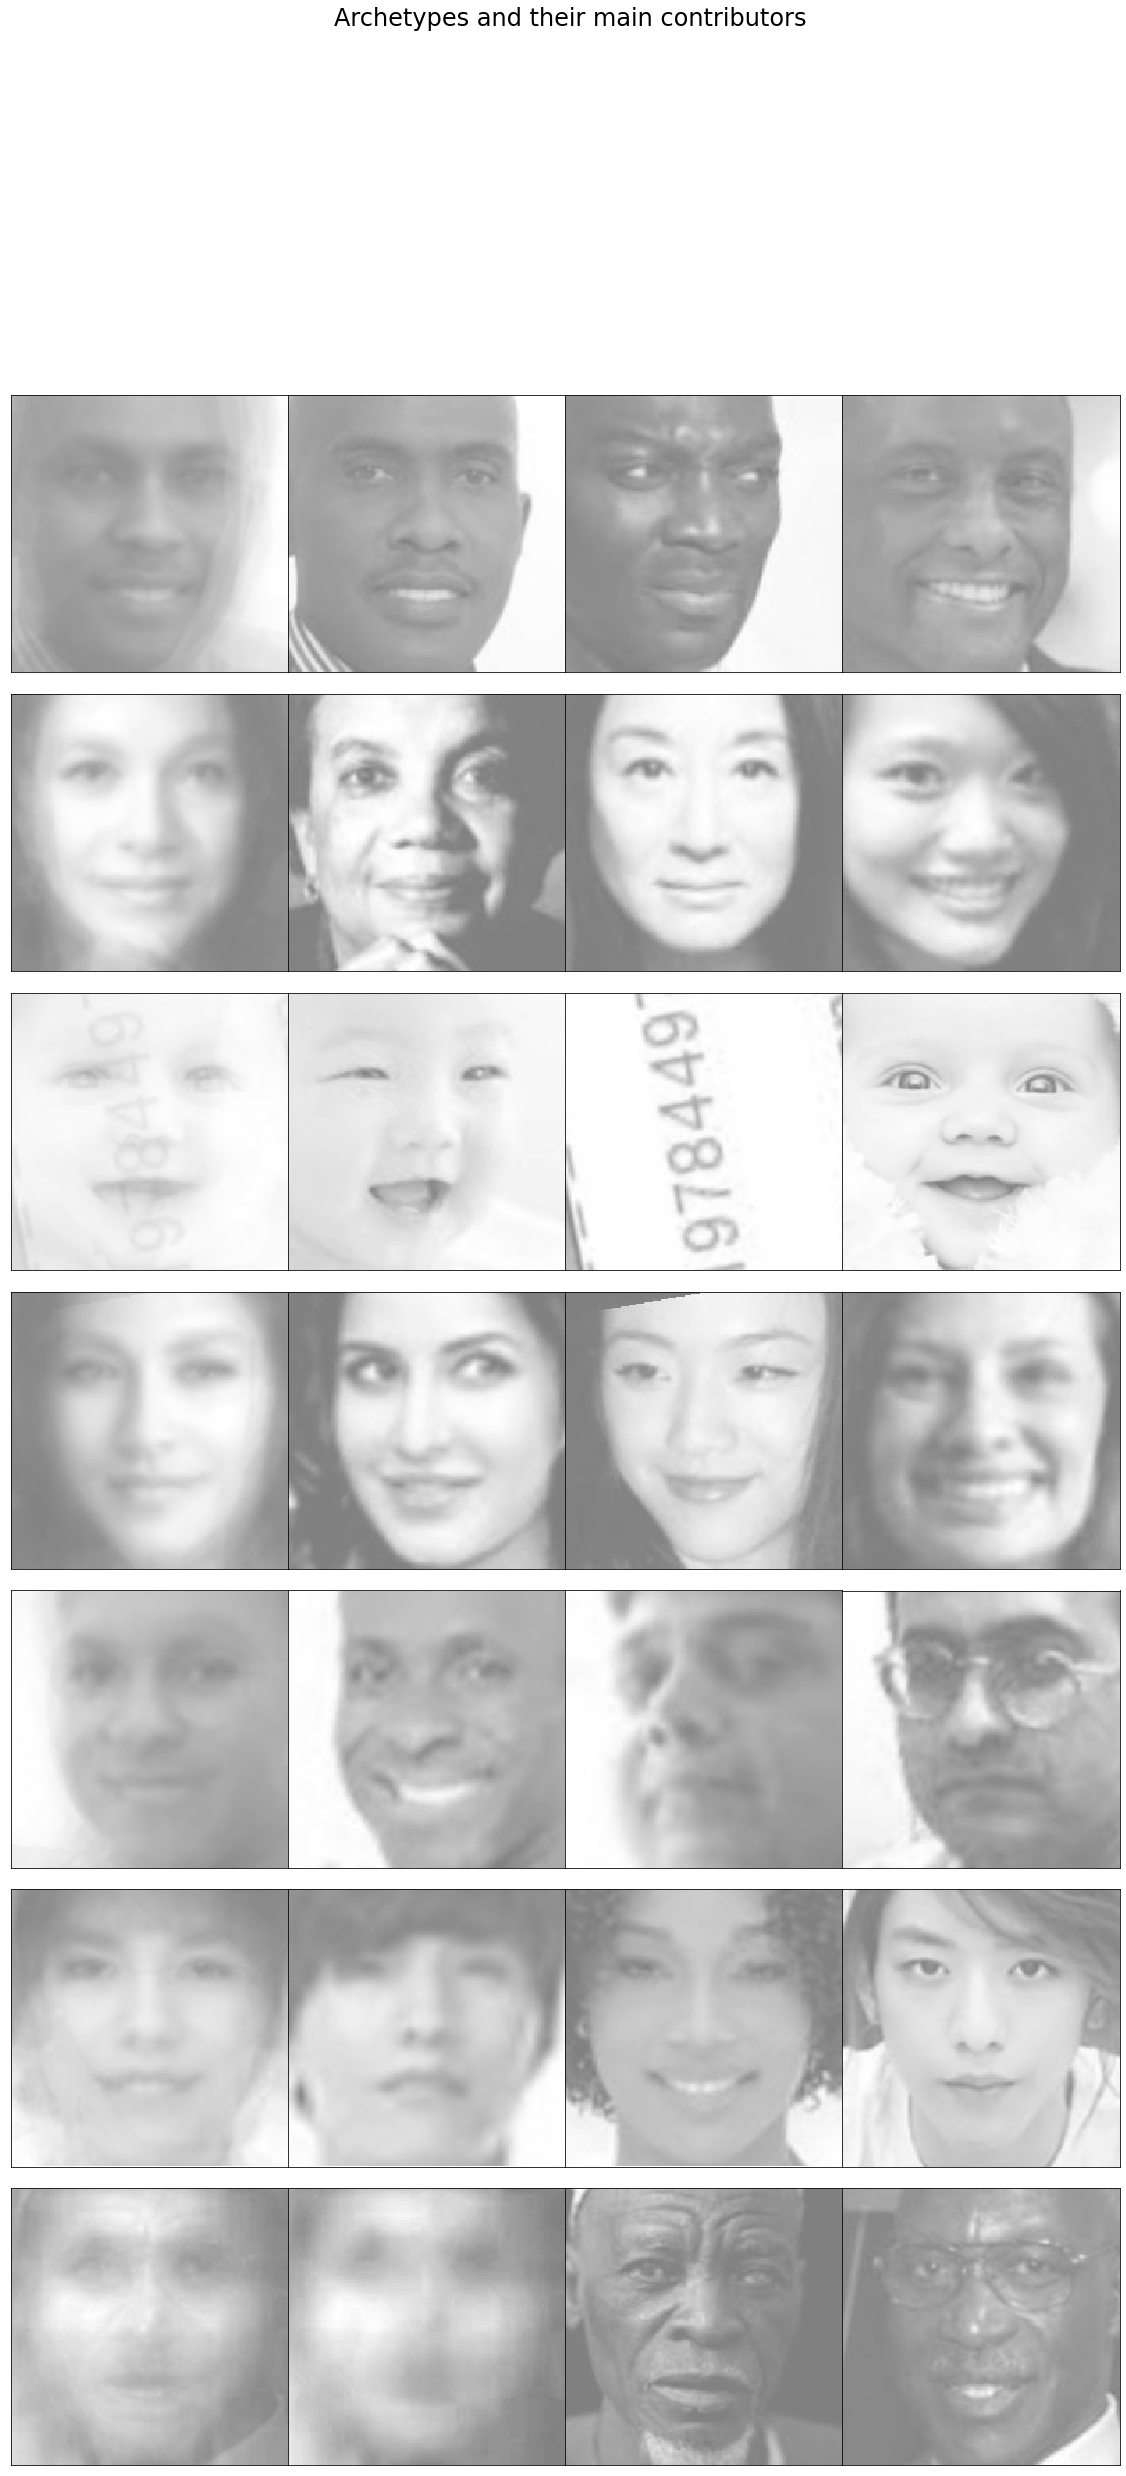

In [155]:
plot_components(f'AA features. Variance explained by AA {1-2*L/SST}', components)
plot_recons(X_hat.T, f'AA reconstructed faces')
plot_arch_contributors('Archetypes and their main contributors', arch_main)

In [61]:
#Switch lables_codes to words
labels_words = copy.deepcopy(filtered_labels)

#gender
labels_words.loc[labels_words.gender == 0, "gender"] = "0_male"
labels_words.loc[labels_words.gender == 1, "gender"] = "1_female"

#race
labels_words.loc[labels_words.race == 0, "race"] = "0_white"
labels_words.loc[labels_words.race == 1, "race"] = "1_black"
labels_words.loc[labels_words.race == 2, "race"] = "2_asian"
labels_words.loc[labels_words.race == 3, "race"] = "3_indian"
labels_words.loc[labels_words.race == 4, "race"] = "4_others"

#age in bins
bins = [0, 2, 4, 13, 20, 60, 200]
lab = ["0_infant", "1_toddler", "2_kid", "3_teen", "4_adult", "5_old"]
labels_words["age"] = pd.cut(labels_words["age"], bins = bins, labels = lab)

In [62]:
#Score matrix, used to understand which labels constitute each component
def arch_score(B, labels):
    '''
    Arguments:
    labels = pandas df. Make sure that the values are unique across the whole dataset. 
             If there is an "A" in the first column, it must not be there in the others
    B = n_component * n_samples (C.T). Every row describes the coefficient for each sample to 
        build the corresponding archetype
    _____________________________________________________________________________________
    Output:
    score_matrix = n_component * possible labels values. Every case describes how much the 
                    corresponding label is present in the component
    '''
    #Get all the unique values of the various labels, sorted   
    cols = []
    for i in range(labels.shape[1]):
        cols += sorted(list(labels.iloc[:,i].unique()))
    labels_values = np.array(cols) #List of the possible values of the labels, ordered "inside" each column
    #print("Labels:",labels_values)
    score_matrix = np.zeros(shape=(np.shape(B)[0], len(labels_values)))
    
    for component_i in range(np.shape(score_matrix)[0]):
        for label_i in range(len(list(labels_values))):
            for sample_i in range(np.shape(B)[1]):
                if labels_values[label_i] in list(labels.iloc[sample_i,:]):
                    score_matrix[component_i, label_i] += B[component_i,sample_i]
    
    return score_matrix, labels_values

In [117]:
#Gender-switch functions
def gender_switch_component_index(wj, labels, scores):
    '''
    Input:
    wj = row in matrix W corresponding to the image to switch gender of
    labels = list of the possible labels in the components scores matrix
             (output of the function arch_score)
    scores = n_components * n_labels . Components scores matrix (output of the function arch_score)
    ___________________________________________________________________________________
    
    Output:
    winner_index = index of the selected component. Increase this component
                    to switch gender
    '''
    #Find the weighted average of the components scores of the input 
    mean_component_score = wj @ scores
    
    #Get the indexes of the genders
    f_i = np.where(labels == '1_female')[0]
    m_i = np.where(labels == '0_male')[0]
    gender_i = [f_i[0], m_i[0]]
    distances = np.zeros(np.shape(scores)[0])

    for r in range(np.shape(scores)[0]):
        distance = np.linalg.norm(scores[r,:] - mean_component_score)
        mf = np.linalg.norm(scores[r,gender_i] - mean_component_score[gender_i]) #gender distance

        distances[r] = distance - 2 * mf

    winner_index = np.argmin(distances)
    
    return winner_index

def add_component(wj, comp_i, coefficient=0.3):
    '''
    Input
    wj = row in matrix W corresponding to the image to switch gender of
    comp_i = index of the component to add
    coefficient = [0-1] How much to increase the new component
    ____________________________________________________________________
    Output
    new = coefficients of the components to reconstruct the new image
    '''
    new = copy.deepcopy(wj) #Deepcopy to not mess with original matrix
    
    #Proportionally decrease old components 
    for component in range(len(new)):
        new[component] = new[component] * (1 - coefficient)
    
    #Add new component
    new[comp_i] += coefficient
    
    return new

In [66]:
archetype_scores, score_labels = arch_score(B = C.T, labels = labels_words)

In [72]:
#Switch gender of the first image
# ind = 13
# win = gender_switch_component_index(wj=S.T[ind], labels=score_labels, scores=archetype_scores)
# new_gender_w = add_component(wj=S.T[ind], comp_i=win, coefficient=0.34)
# new_fem = new_gender_w @ XC.T

In [ ]:
#Image (ind)
# plt.imshow((X_hat.T[ind,:]).reshape(h,w), cmap='gray')

In [ ]:
#Image (ind) (gender switched)
# plt.imshow((new_fem[0,:]).reshape(h,w), cmap='gray')

In [149]:
def plot_gender_switch(title, reconstructions = X_hat.T, W=S.T, H=XC.T, labels=score_labels, scores=archetype_scores):
    '''
    Plot random samples (first column) and three gradations of gender switch
    '''
    #Choose random samples to visualize
    n_samples = 5
    coefficients = [0, 0.4, 0.6, 0.9]
    indexes = []
    
    for i in range(0, n_samples):
        n = random.randint(0, np.shape(X_hat.T)[0])
        indexes.append(n)
        
    plt.figure(figsize= (image_shape[1]/90 * len(coefficients), image_shape[0]/40 * n_samples))
    plt.suptitle(title, size=24)
    
    pos = 1

    for ind in indexes:  #For every selected image
        winner = gender_switch_component_index(wj=W[ind], labels=labels, scores=scores)
        
        
        for coeff in coefficients:   #Plot various shades of switch
            new_g = add_component(wj=S.T[ind], comp_i=winner, coefficient=coeff)
            swapped = new_g @ H
            plt.subplot(n_samples, 4, pos)
        
            # normalize colormap
            vmax = max(swapped.max(), -swapped.min())
            plt.imshow(swapped.reshape(image_shape), cmap=plt.cm.gray,
                       interpolation='nearest',
                       vmin=-vmax, vmax=vmax)
            # Remove ticks from plot
            plt.xticks(())
            plt.yticks(())
        
            pos += 1
    #Runtime to save different files
    now = datetime.now()
    current_time = now.strftime("%H%M%S")
    
    
    
    plt.savefig(f'Switches\Switch_{current_time}_{n_comp}comp.png')
    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

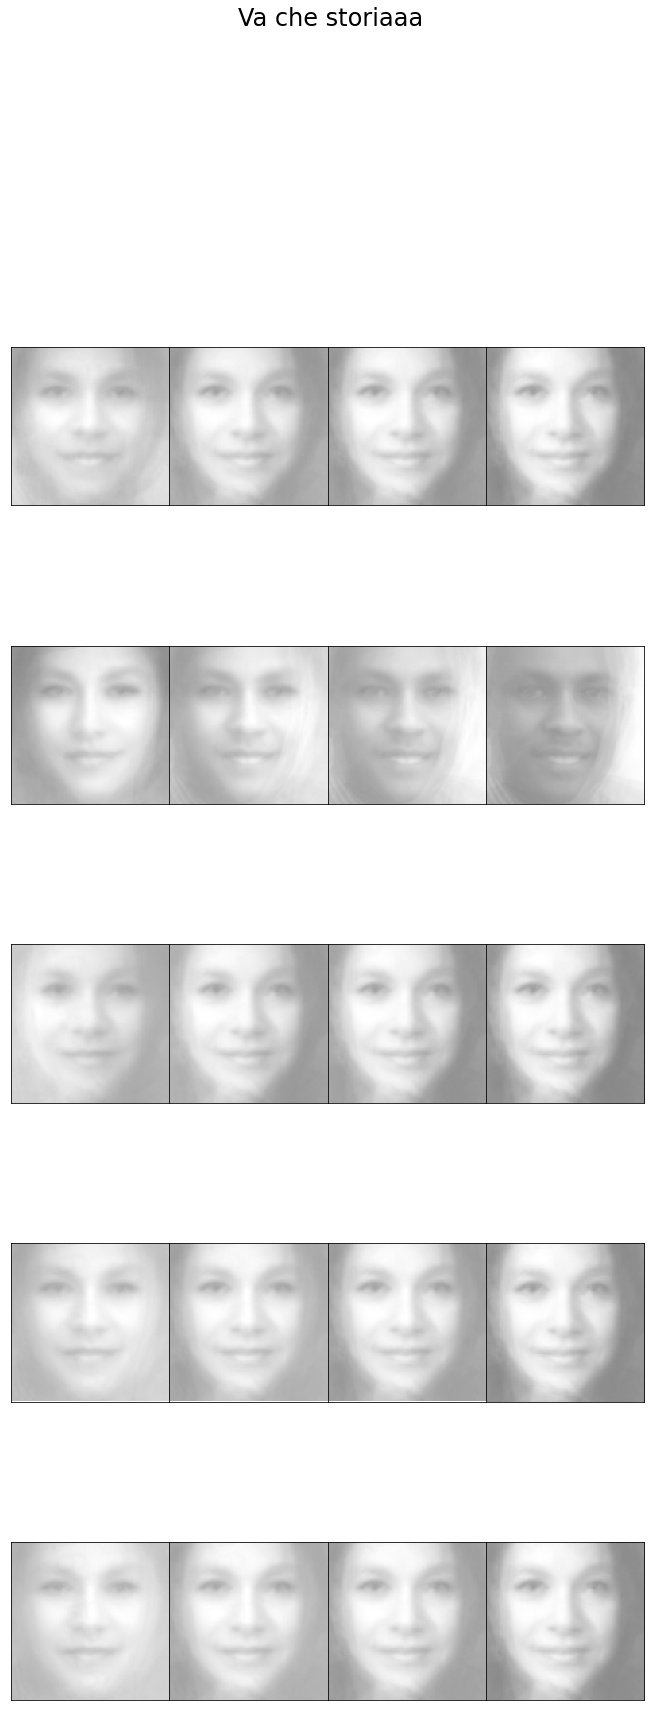

In [150]:
plot_gender_switch("Va che storiaaa")

In [156]:
dir()

['C',
 'In',
 'KFold',
 'KNeighborsClassifier',
 'L',
 'LogisticRegression',
 'Out',
 'PCA',
 'S',
 'SSE',
 'SST',
 'SSe',
 'StratifiedKFold',
 'X',
 'XC',
 'X_hat',
 'Xmain',
 '_',
 '_15',
 '_24',
 '_38',
 '_39',
 '_42',
 '_46',
 '_47',
 '_49',
 '_53',
 '_57',
 '_SEED',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i100',
 '_i101',
 '_i102',
 '_i103',
 '_i104',
 '_i105',
 '_i106',
 '_i107',
 '_i108',
 '_i109',
 '_i11',
 '_i110',
 '_i111',
 '_i112',
 '_i113',
 '_i114',
 '_i115',
 '_i116',
 '_i117',
 '_i118',
 '_i119',
 '_i12',
 '_i120',
 '_i121',
 '_i122',
 '_i123',
 '_i124',
 '_i125',
 '_i126',
 '_i127',
 '_i128',
 '_i129',
 '_i13',
 '_i130',
 '_i131',
 '_i132',
 '_i133',
 '_i134',
 '_i135',
 '_i136',
 '_i137',
 '_i138',
 '_i139',
 '_i14',
 '_i140',
 '_i141',
 '_i142',
 '_i143',
 '_i144',
 '_i145',
 '_i146',
 '_i147',
 '_i148',
 '_i149',
 '_i15',
 '_i150',
 '_i151',
 '_i152',
 '_i